In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import pickle

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import pickle
from pymc import HalfCauchy, Model, Normal, sample
print(f"Running on PyMC v{pm.__version__}")

from scipy.stats import pearsonr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.6.0


In [2]:
data_all = pd.read_csv("Data/10pctimpx_forJZ.csv")

S_tensor = pd.read_csv("Data/Sampling_tensor.csv", index_col=0, header=None)
line_names = pd.Series(S_tensor.index)

data = pd.read_csv("Data/10pctimpx_forJZ.csv")
print(data.shape)
data = data[np.array(data['LineType'] == "G0")  | np.array(data['LineType'] == "RIL") | np.array(data['LineType'] == "RIAIL")]
print(data.shape)
num_nas = np.isnan(data.iloc[:, 7:].to_numpy()).sum(1)
data = data[num_nas < 169] # filter all lines without genotype info
geno_all = data.iloc[:, 7:].to_numpy()
n, L = geno_all.shape

(3030, 176)
(2757, 176)


In [3]:
par_dict = dict(zip(['G0', 'P530', 'P563'], line_names[:3]))

Line_new = []
for row in range(data.shape[0]):
    linetype = data.iloc[row].LineType
    line_num = data.iloc[row]['Linex']
    if (linetype != "RIL")  and (linetype != "RIAIL" ):
        Line_new.append(par_dict[linetype])
    else:
        if linetype == "RIL":
            Line_new.append(linetype + "_" + str(line_num - 200))
        else: Line_new.append(linetype + "_" + str(line_num))
data.Linex = Line_new

set(line_names).difference(set(data.Linex.unique())) ## Line names are the same in the genotype file and phenotype file

{'MA530', 'MA563'}

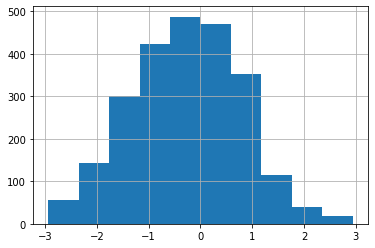

In [4]:
from scipy.sparse import coo_matrix
# Generate A matrix for mapping geno to geno_expand
line2num = dict(zip(line_names, range(len(line_names))))
row_idx, col_idx = np.arange(len(data)), np.array([line2num[line] for line in data.Linex])
A = coo_matrix((np.ones(len(row_idx)), (row_idx, col_idx)))
# Turn block to dummy variables
data.block = data.block.astype("str")
block = pd.get_dummies(data.block).to_numpy()

y = data.ln_ci
y.hist()
plt.show()

### Simulate data

In [23]:
import os

directory = "LD_h2_simulation"

# Create the directory if it does not exist
os.makedirs(directory, exist_ok=True)

#### Asymmetric gamma

In [12]:
def sample_mut():
    mut_pos = np.random.gamma(shape=alpha_pos, scale=1/beta_pos, size=L)
    mut_neg = -1 * np.random.gamma(shape=alpha_neg, scale=1/beta_neg, size=L)
    M = np.stack([mut_neg, mut_pos]).T
    In = np.eye(2)[np.random.binomial(n=1, p=p_pos, size=L)]
    mut = (M*In).sum(1)    
    return mut

In [13]:
def permute_rows_individually(array):
    permuted_array = np.empty_like(array)
    for i in range(array.shape[0]):
        permuted_array[i] = np.random.permutation(array[i])
    return permuted_array

In [14]:
p_pos = 0.5014388319648195

alpha_pos, beta_pos = 0.66625288920606, 15.711950660777102

alpha_neg, beta_neg = 0.8529779320558907, 14.938469551412519

std = 0.9812639423060024

In [15]:
# only simulated based on the RILs

S_RIL = S_tensor[['RIL' in ID for ID in S_tensor.index]]

A_RIL = A.toarray()[np.where(['RIL' in id for id in data.Linex])[0]][:, np.where(['RIL' in id for id in line2num.keys()])[0]]

G_RIL = np.round(S_RIL).to_numpy()

n_RILs = A_RIL.shape[0]

line_RILs = list(data.Linex[-n_RILs:])
reps = [np.sum([l == line_RILs[i] for l in line_RILs[:i + 1]]) for i in range(n_RILs)]

##### Unpaired data

In [10]:
for i in range(100):

    G_perm = permute_rows_individually(G_RIL)
    mut = sample_mut()
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/permuted_genotypes_sample_{i}.csv", index=None)

In [11]:
for i in range(100):

    G_perm = G_RIL
    mut = sample_mut()
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/original_genotypes_sample_{i}.csv", index=None)

In [29]:
!zip -r LD_h2_simulation/permuted_genotypes.zip LD_h2_simulation/permuted_genotypes*
!zip -r LD_h2_simulation/original_genotypes.zip LD_h2_simulation/original_genotypes*

##### Paired simulated data

In [167]:
for i in range(100):
    
    mut = sample_mut()

    # random genotypes
    G_perm = permute_rows_individually(G_RIL)
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/permuted_genotypes_sample_{i}.csv", index=None)
    
    # original genotypes
    
    G_perm = G_RIL
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/original_genotypes_sample_{i}.csv", index=None)    

In [168]:
!zip -r LD_h2_simulation/permuted_genotypes.zip LD_h2_simulation/permuted_genotypes*
!zip -r LD_h2_simulation/original_genotypes.zip LD_h2_simulation/original_genotypes*

updating: LD_h2_simulation/permuted_genotypes_sample_0.csv (deflated 96%)
updating: LD_h2_simulation/permuted_genotypes_sample_10.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_11.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_12.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_13.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_14.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_15.csv (deflated 96%)
updating: LD_h2_simulation/permuted_genotypes_sample_16.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_17.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_18.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_19.csv (deflated 96%)
updating: LD_h2_simulation/permuted_genotypes_sample_1.csv (deflated 95%)
updating: LD_h2_simulation/permuted_genotypes_sample_20.csv (deflated 95%)
updating: LD_h2_simulation/

#### Simulate under negative Gamma model

In [18]:
def sample_mut():
    mut_neg = -1 * np.random.gamma(shape=alpha_neg, scale=1/beta_neg, size=L)
    return mut_neg

def permute_rows_individually(array):
    permuted_array = np.empty_like(array)
    for i in range(array.shape[0]):
        permuted_array[i] = np.random.permutation(array[i])
    return permuted_array

In [16]:
alpha_neg, beta_neg = 0.0423, 5.755

std = 0.999

In [19]:
# Only use RILs

S_RIL = S_tensor[['RIL' in ID for ID in S_tensor.index]]

A_RIL = A.toarray()[np.where(['RIL' in id for id in data.Linex])[0]][:, np.where(['RIL' in id for id in line2num.keys()])[0]]

G_RIL = np.round(S_RIL).to_numpy()

n_RILs = A_RIL.shape[0]

line_RILs = list(data.Linex[-n_RILs:])
reps = [np.sum([l == line_RILs[i] for l in line_RILs[:i + 1]]) for i in range(n_RILs)]

##### Simulated unpaired data

In [90]:
for i in range(100):

    G_perm = permute_rows_individually(G_RIL)
    mut = sample_mut()
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/neg_gamma_permuted_genotypes_sample_{i}.csv", index=None)

In [42]:
for i in range(100):

    G_perm = G_RIL
    mut = sample_mut()
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/neg_gamma_original_genotypes_sample_{i}.csv", index=None)

In [43]:
!zip -r LD_h2_simulation/neg_gamma_permuted_genotypes.zip LD_h2_simulation/neg_gamma_permuted_genotypes*
!zip -r LD_h2_simulation/neg_gamma_original_genotypes.zip LD_h2_simulation/neg_gamma_original_genotypes*

  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_0.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_10.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_11.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_12.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_13.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_14.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_15.csv (deflated 96%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_16.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_17.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_18.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_19.csv (deflated 95%)
  adding: LD_h2_simulation/neg_gamma_permuted_genotypes_sample_1.c

##### Simulated paired data

In [44]:
for i in range(100):
    
    mut = sample_mut()

    # random genotypes
    G_perm = permute_rows_individually(G_RIL)
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/neg_gamma_permuted_genotypes_sample_{i}.csv", index=None)
    
    # original genotypes
    
    G_perm = G_RIL
    g = np.matmul(G_perm, mut)
    
    G_ex = np.matmul(A_RIL, G_perm)
    g_ex = np.matmul(A_RIL, g)
    
    noise = np.random.normal(loc=0, scale=std, size=len(G_ex))
    y = g_ex + noise

    dat = np.append(G_ex, np.expand_dims(y, 1), axis=1)

    dat = pd.DataFrame(dat)

    dat.columns = ['x' + str(locus) for locus in list(S_RIL.columns)] + ['y']
    
    dat.insert(0, 'Line', line_RILs)  # Insert at position 0 (leftmost)
    dat.insert(1, 'Replicate', reps)  # Insert at position 0 (leftmost)    

    dat.to_csv(f"LD_h2_simulation/neg_gamma_original_genotypes_sample_{i}.csv", index=None)    

In [20]:
!zip -r LD_h2_simulation/neg_gamma_permuted_genotypes.zip LD_h2_simulation/neg_gamma_permuted_genotypes*
!zip -r LD_h2_simulation/neg_gamma_original_genotypes.zip LD_h2_simulation/neg_gamma_original_genotypes*